In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
products = pd.read_csv(r"C:\Users\abuob\Downloads\Products.csv")
customers = pd.read_csv(r"C:\Users\abuob\Downloads\Customers.csv")
transactions = pd.read_csv(r"C:\Users\abuob\Downloads\Transactions.csv")

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")
merged_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


In [6]:
# Create customer-level features
customer_features = merged_data.groupby("CustomerID").agg({
    "Quantity": "sum",             # Total quantity purchased
    "Price_x": "mean",               # Average price of products purchased
    "TransactionID": "count",      # Number of transactions
    "Region": "first",             # Customer's region
    "SignupDate": "first"          # Signup date
}).reset_index()

In [7]:
# Calculate total spend per customer
customer_features["TotalSpend"] = customer_features["Quantity"] * customer_features["Price_x"]

In [8]:
# Extract signup year
customer_features["SignUpYear"] = pd.to_datetime(customer_features["SignupDate"]).dt.year
customer_features.drop("SignupDate", axis=1, inplace=True)

In [9]:
customer_features = merged_data.groupby("CustomerID").agg({
    "Quantity": "sum",
    "Price_x": "mean",
    "Region": "first"  # Ensure 'Region' is included
}).reset_index()

# Convert Region to string
customer_features["Region"] = customer_features["Region"].astype(str)

In [10]:
# One-hot encode the Region column
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

In [12]:
from sklearn.preprocessing import StandardScaler
# Scale numerical features
scaler = StandardScaler()
normalized_features = customer_features.copy()
normalized_features.iloc[:, 1:] = scaler.fit_transform(customer_features.iloc[:, 1:])

In [13]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features.drop("CustomerID", axis=1))
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(normalized_features.drop("CustomerID", axis=1), kmeans.labels_))

C:\Users\abuob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abuob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abuob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\abuob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

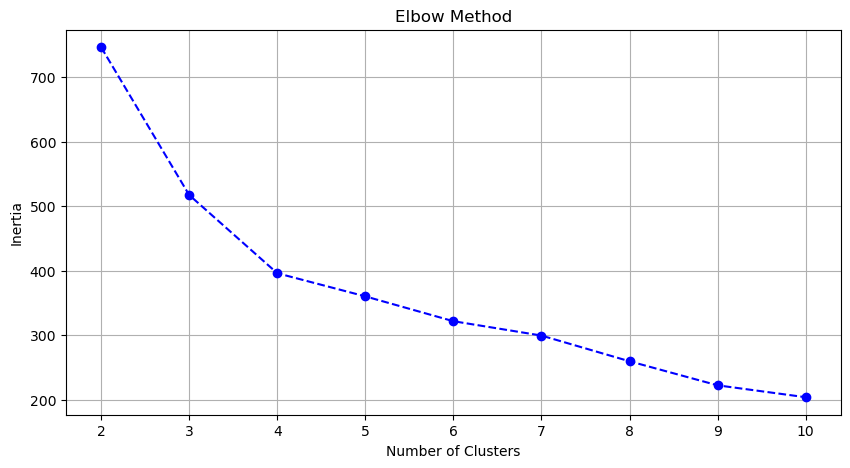

In [14]:
# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--', color='b')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

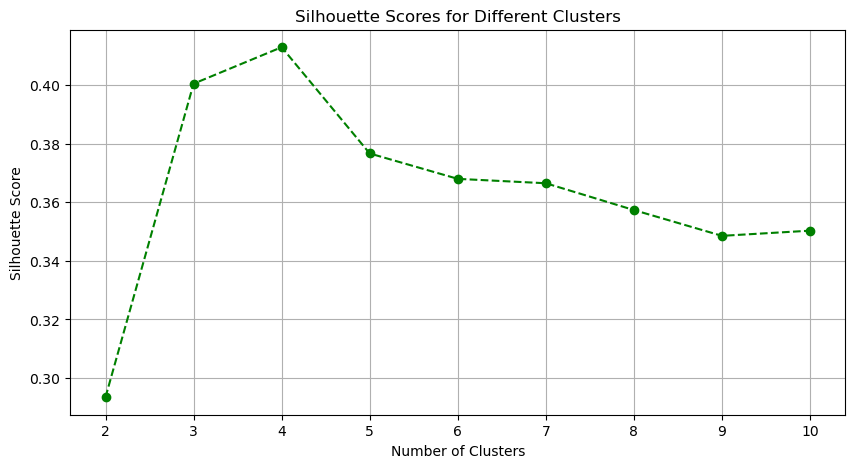

In [15]:
# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='g')
plt.title("Silhouette Scores for Different Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid()
plt.show()

In [16]:
from sklearn.metrics import davies_bouldin_score

In [17]:
# Based on the elbow method and silhouette scores, choose an optimal number of clusters
optimal_clusters = 4  # Replace this with the optimal value based on the plots

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(normalized_features.drop("CustomerID", axis=1))

# Evaluate Clustering Performance
db_index = davies_bouldin_score(normalized_features.drop("CustomerID", axis=1), kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.0909728199954827


C:\Users\abuob\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [18]:
# Visualize Clusters (using PCA for 2D visualization)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features.drop("CustomerID", axis=1))
reduced_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
reduced_df["Cluster"] = customer_features["Cluster"]

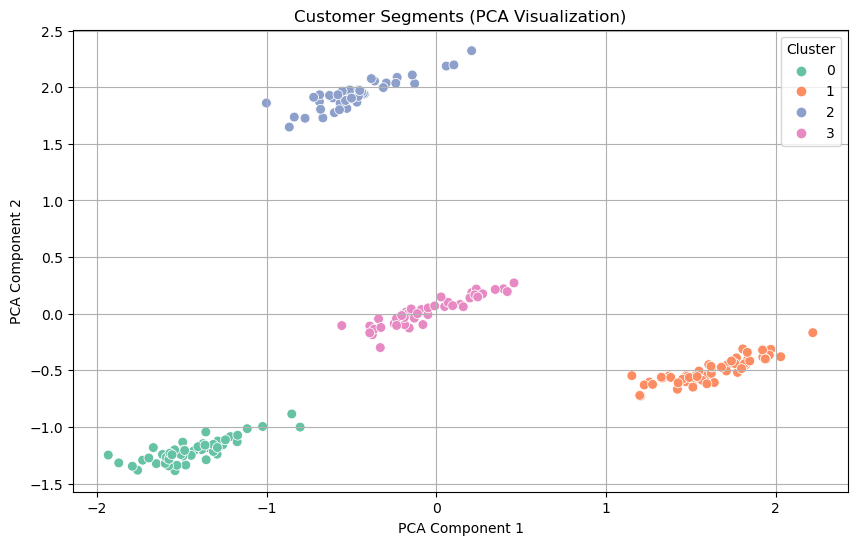

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=50)
plt.title("Customer Segments (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()